
#Installing Dependencies and Reading in Data

In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Flatten,Input
from keras.layers import Embedding,LSTM,Bidirectional,GRU,SimpleRNN
from keras.layers import concatenate
from keras.utils import to_categorical
from IPython.display import SVG
#from keras.utils import model_to_dot
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
train_data = pd.read_csv('/content/drive/Shareddrives/CS772/training.csv')
test_data= pd.read_csv('/content/drive/Shareddrives/CS772/golden_test.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Please uncomment the following if not able to read files as above
#from google.colab import upload
#uploaded=files.upload()
#train_data=pd.read_csv('train.csv')
#test_data=pd.read_csv('gold_test.csv')

In [ ]:
display(train_data,test_data)

,Unnamed: 0,reviews,ratings
0,0,"This book was very informative, covering all a...",4
1,1,I am already a baseball fan and knew a bit abo...,5
2,2,I didn't like this product it smudged all unde...,1
3,3,I simply love the product. I appreciate print ...,5
4,4,It goes on very easily and makes my eyes look ...,5
...,...,...,...
49995,49995,it does not work((((((((((((,1
49996,49996,"Really worthless, loud motor with absolutely n...",1
49997,49997,Don't waste your money on this. It does nothin...,1
49998,49998,"Product does not remove ear wax. No suction, j...",1


,Unnamed: 0,reviews,ratings
0,0,Doesn't work at ALL. Don't waste your money or...,1
1,1,What crap. Would need a lot more power to do ...,1
2,2,Has no suction and didn't work. Not worth trying.,1
3,3,That is definitely a trash. Unable to clean an...,1
4,4,Didn't even worked on cleaning the ears at all...,1
...,...,...,...
9995,9995,Awesome product for all types of skin! Helped...,5
9996,9996,So easy to use. This is great option for helpi...,5
9997,9997,Such a great product to help with razor bumps ...,5
9998,9998,Perfect product to apply to razor burn on my b...,5


#Preprocessing textual Data:


*   Converting Data to Lower Case
*   Removing Punctuation

*    Converting ratings into one hot encodings
*    Dividing training set further into training and validation

The data is preprocessed to use as 

*   Representations without any pre-trained embeddings
*   Using Glove Pre-trained Embedding

In [ ]:
def remove_punctuation(text):
  no_pun=[char for char in text if char not in string.punctuation]
  no_pun=''.join(no_pun)
  return no_pun

def remove_stopwords(text):
  stop_words=set(stopwords.words('english'))
  sent=''
  for i in text.split():
    if i not in stop_words:
      sent+=i+" "
  return sent

reviews_train=train_data['reviews']
reviews_test =test_data['reviews']
#Converting text to all lower case letters.
reviews_train=reviews_train.apply(lambda x:x.lower())
reviews_test=reviews_test.apply(lambda x:x.lower())
#Removing Punctuation
reviews_train=reviews_train.apply(remove_punctuation)
reviews_test=reviews_test.apply(remove_punctuation)
#Removing StopWords
# """Stopwords are those words which are very commonly used and do not add
# a lot to the sentiment of the sentences which is the major goal."""
# reviews_train=reviews_train.apply(remove_stopwords)
# reviews_test=reviews_test.apply(remove_stopwords)

In [ ]:
(count, col) = train_data.shape
texts_train = []
for i in range (0, count):
  texts_train.append(reviews_train[i])

(count_test, col_train) = test_data.shape
texts_test = []
for i in range (0, count_test):
  texts_test.append(reviews_test[i])

In [ ]:
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 52
#Note that MAX_SEQUENCE_LENGTH is an important parameter
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts_train)
vocab_size = len(tokenizer.word_index) + 1

sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

train_X = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_X = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

Found 19490 unique tokens.


In [ ]:
display(X_training)

array([[ 443,  217, 1680, ...,    0,    0,    0],
       [  57,  136,    9, ...,    0,    0,    0],
       [  74,    3, 7060, ...,    0,    0,    0],
       ...,
       [   1,  228,   10, ...,    0,    0,    0],
       [  89,   59,    9, ...,    0,    0,    0],
       [   3,   14,    6, ...,    0,    0,    0]], dtype=int32)

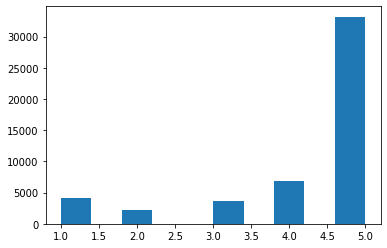

5    33193
4     6871
1     4059
3     3612
2     2265
Name: ratings, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_data.ratings)
plt.show()
train_data['ratings'].value_counts()

Clearly the data is imbalanced and we need to do something to get over the imbalance.

#Working for Data Imbalance
Using UnderSampling to reduce imbalance at class 5.

In [ ]:
le = LabelEncoder()
train_y = le.fit_transform(train_data.ratings)
test_y = le.fit_transform(test_data.ratings)
train_y = to_categorical(np.asarray(train_y))
test_y= to_categorical(np.asarray(test_y))
X_training, X_validating, Y_training, Y_validating = train_test_split(train_X, train_y,stratify = train_y, test_size=0.15, random_state = 40)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
undersample=RandomUnderSampler(sampling_strategy={1:4059,2:2265,3:3612,4:6871,5:15000})
oversample=RandomOverSampler(sampling_strategy={1:8000,2:8000,3:8000,4:8000,5:33193})
X_under,Y_under=oversample.fit_resample(train_X,train_data.ratings)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
display(X_training,X_validating)
display(Y_training,Y_validating)
print(len(X_training),len(X_validating))

array([[ 443,  217, 1680, ...,    0,    0,    0],
       [  57,  136,    9, ...,    0,    0,    0],
       [  74,    3, 7060, ...,    0,    0,    0],
       ...,
       [   1,  228,   10, ...,    0,    0,    0],
       [  89,   59,    9, ...,    0,    0,    0],
       [   3,   14,    6, ...,    0,    0,    0]], dtype=int32)

array([[   6,  187,   10, ...,    0,    0,    0],
       [   9,    1,  460, ...,    0,    0,    0],
       [  12,   23,  147, ...,    0,    0,    0],
       ...,
       [  11, 2312,  141, ...,    0,    0,    0],
       [  19,   12,    4, ...,    0,    0,    0],
       [  89,   59,    9, ...,    0,    0,    0]], dtype=int32)

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

42500 7500


# Building The Various Models without any Pretrained Embedding

Models are:

*   RNN
*   LSTM
*   Bi-LSTM
*   GRU
*   Bi-GRU

#Using RNNs

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 52, 100)           1949100   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
Total params: 1,971,855
Trainable params: 1,971,855
Non-trainable params: 0
_________________________________________________________________
None


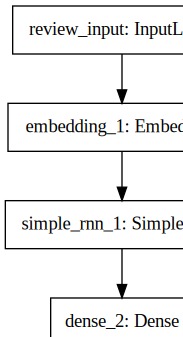

In [ ]:
# Add sequential model
sentiment_rnn = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size,100, input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Rnn_Layer = SimpleRNN(100)
Rnn = Rnn_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Rnn)
predict = Dense(5,activation='softmax')(dense1)

sentiment_rnn = Model(inputs=[review_input],outputs=[predict])
sentiment_rnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_rnn.summary())
SVG(model_to_dot(sentiment_rnn).create(prog='dot', format='svg'))

In [ ]:
sentiment_rnn.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 69s 51ms/step - loss: 1.1301 - acc: 0.6397 - val_loss: 1.0794 - val_acc: 0.6639
Epoch 2/5
1329/1329 [==============================] - 68s 51ms/step - loss: 1.0733 - acc: 0.6668 - val_loss: 1.0808 - val_acc: 0.6639
Epoch 3/5
1329/1329 [==============================] - 67s 50ms/step - loss: 1.0890 - acc: 0.6600 - val_loss: 1.0799 - val_acc: 0.6639
Epoch 4/5
1329/1329 [==============================] - 68s 51ms/step - loss: 1.0682 - acc: 0.6684 - val_loss: 1.0798 - val_acc: 0.6637
Epoch 5/5
1329/1329 [==============================] - 67s 51ms/step - loss: 1.0790 - acc: 0.6645 - val_loss: 1.0795 - val_acc: 0.6637


In [ ]:
test_loss, test_acc=sentiment_rnn.evaluate(test_X,test_y)
pred_Y=sentiment_rnn.predict(test_X)
print('Test Classification Report:')
predictions=[]
for i in range(len(pred_Y)):
  predictions.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions))

313/313 [==============================] - 2s 5ms/step - loss: 1.2665 - acc: 0.5784
Test Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1271
           2       0.00      0.00      0.00       630
           3       0.00      0.00      0.00       911
           4       0.00      0.00      0.00      1404
           5       0.58      1.00      0.73      5784

    accuracy                           0.58     10000
   macro avg       0.12      0.20      0.15     10000
weighted avg       0.33      0.58      0.42     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix(test_data.ratings,predictions)

NameError: ignored

#Using LSTMs

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 52, 100)           1949100   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 130       
Total params: 2,032,155
Trainable params: 2,032,155
Non-trainable params: 0
_________________________________________________________________
None


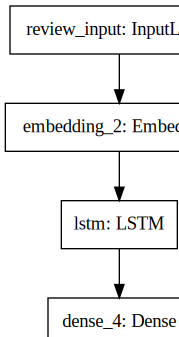

In [ ]:
# Add sequential model
sentiment_lstm = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size,100, input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Lstm_Layer = LSTM(100)
Lstm = Lstm_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Lstm)
predict = Dense(5,activation='softmax')(dense1)

sentiment_lstm = Model(inputs=[review_input],outputs=[predict])
sentiment_lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_lstm.summary())
SVG(model_to_dot(sentiment_lstm).create(prog='dot', format='svg'))

In [ ]:
sentiment_lstm.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 56s 21ms/step - loss: 1.1673 - acc: 0.6229 - val_loss: 1.0788 - val_acc: 0.6639
Epoch 2/5
1329/1329 [==============================] - 27s 20ms/step - loss: 1.0720 - acc: 0.6674 - val_loss: 1.0789 - val_acc: 0.6639
Epoch 3/5
1329/1329 [==============================] - 27s 21ms/step - loss: 1.0880 - acc: 0.6599 - val_loss: 1.0792 - val_acc: 0.6639
Epoch 4/5
1329/1329 [==============================] - 27s 20ms/step - loss: 1.0901 - acc: 0.6585 - val_loss: 1.0791 - val_acc: 0.6639
Epoch 5/5
1329/1329 [==============================] - 27s 20ms/step - loss: 1.0863 - acc: 0.6599 - val_loss: 1.0790 - val_acc: 0.6639


In [ ]:
test_loss, test_acc=sentiment_lstm.evaluate(test_X,test_y)
pred_Y=sentiment_lstm.predict(test_X)
print('Test Classification Report:')
predictions=[]
for i in range(len(pred_Y)):
  predictions.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions))

313/313 [==============================] - 1s 3ms/step - loss: 1.2687 - acc: 0.5784
Test Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1271
           2       0.00      0.00      0.00       630
           3       0.00      0.00      0.00       911
           4       0.00      0.00      0.00      1404
           5       0.58      1.00      0.73      5784

    accuracy                           0.58     10000
   macro avg       0.12      0.20      0.15     10000
weighted avg       0.33      0.58      0.42     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Using Bi-LSTMs

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 52, 100)           1949100   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_6 (Dense)              (None, 25)                5025      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 130       
Total params: 2,115,055
Trainable params: 2,115,055
Non-trainable params: 0
_________________________________________________________________
None


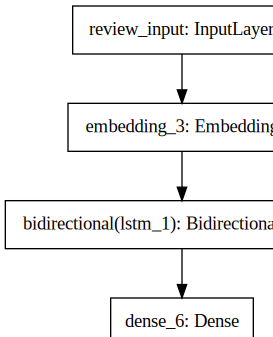

In [ ]:
# Add sequential model
sentiment_bilstm = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 100, input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Lstm_Layer = Bidirectional(LSTM(100))
Lstm = Lstm_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Lstm)
predict = Dense(5,activation='softmax')(dense1)

sentiment_bilstm= Model(inputs=[review_input],outputs=[predict])
sentiment_bilstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_bilstm.summary())
SVG(model_to_dot(sentiment_bilstm).create(prog='dot', format='svg'))

In [ ]:
sentiment_bilstm.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 34s 24ms/step - loss: 1.0178 - acc: 0.6477 - val_loss: 0.7189 - val_acc: 0.7380
Epoch 2/5
1329/1329 [==============================] - 31s 23ms/step - loss: 0.6591 - acc: 0.7520 - val_loss: 0.6791 - val_acc: 0.7496
Epoch 3/5
1329/1329 [==============================] - 30s 23ms/step - loss: 0.5551 - acc: 0.7909 - val_loss: 0.6885 - val_acc: 0.7519
Epoch 4/5
1329/1329 [==============================] - 30s 23ms/step - loss: 0.4891 - acc: 0.8196 - val_loss: 0.6935 - val_acc: 0.7471
Epoch 5/5
1329/1329 [==============================] - 31s 23ms/step - loss: 0.4208 - acc: 0.8481 - val_loss: 0.7430 - val_acc: 0.7479


In [ ]:
test_loss, test_acc=sentiment_bilstm.evaluate(test_X,test_y)
pred_Y=sentiment_bilstm.predict(test_X)
print('Test Classification Report:')
predictions=[]
for i in range(len(pred_Y)):
  predictions.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions))

313/313 [==============================] - 1s 4ms/step - loss: 0.9309 - acc: 0.6832
Test Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.58      0.64      1271
           2       0.25      0.23      0.24       630
           3       0.35      0.39      0.37       911
           4       0.37      0.25      0.30      1404
           5       0.81      0.91      0.86      5784

    accuracy                           0.68     10000
   macro avg       0.50      0.47      0.48     10000
weighted avg       0.66      0.68      0.67     10000



#Using GRUs

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 52, 64)            1247424   
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1625      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 130       
Total params: 1,274,139
Trainable params: 1,274,139
Non-trainable params: 0
_________________________________________________________________
None


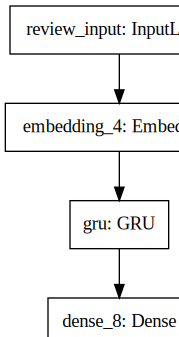

In [ ]:
# Add sequential model
sentiment_gru = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 64, input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Gru_Layer = GRU(64)
Gru = Gru_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Gru)
predict = Dense(5,activation='softmax')(dense1)

sentiment_gru = Model(inputs=[review_input],outputs=[predict])
sentiment_gru.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_gru.summary())
SVG(model_to_dot(sentiment_gru).create(prog='dot', format='svg'))

In [ ]:
sentiment_gru.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 19s 13ms/step - loss: 1.0331 - acc: 0.6673 - val_loss: 0.7611 - val_acc: 0.7143
Epoch 2/5
1329/1329 [==============================] - 18s 13ms/step - loss: 0.6922 - acc: 0.7379 - val_loss: 0.6853 - val_acc: 0.7467
Epoch 3/5
1329/1329 [==============================] - 18s 13ms/step - loss: 0.5719 - acc: 0.7831 - val_loss: 0.6941 - val_acc: 0.7484
Epoch 4/5
1329/1329 [==============================] - 17s 13ms/step - loss: 0.4957 - acc: 0.8170 - val_loss: 0.7295 - val_acc: 0.7393
Epoch 5/5
1329/1329 [==============================] - 18s 13ms/step - loss: 0.4351 - acc: 0.8443 - val_loss: 0.7426 - val_acc: 0.7343


In [ ]:
test_loss, test_acc=sentiment_gru.evaluate(test_X,test_y)
pred_Y=sentiment_gru.predict(test_X)
print('Test Classification Report:')
predictions=[]
for i in range(len(pred_Y)):
  predictions.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions))

313/313 [==============================] - 1s 3ms/step - loss: 0.9150 - acc: 0.6743
Test Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.59      0.63      1271
           2       0.25      0.19      0.22       630
           3       0.35      0.38      0.37       911
           4       0.34      0.28      0.31      1404
           5       0.82      0.89      0.85      5784

    accuracy                           0.67     10000
   macro avg       0.49      0.47      0.48     10000
weighted avg       0.66      0.67      0.66     10000



#Using Bi-GRUs

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 52, 100)           1949100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               121200    
_________________________________________________________________
dense_10 (Dense)             (None, 25)                5025      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 130       
Total params: 2,075,455
Trainable params: 2,075,455
Non-trainable params: 0
_________________________________________________________________
None


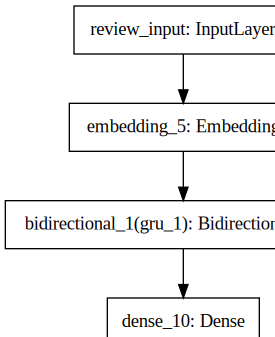

In [ ]:
# Add sequential model
sentiment_bigru = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 100,input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Gru_Layer = Bidirectional(GRU(100))
Gru = Gru_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Gru)
predict = Dense(5,activation='softmax')(dense1)

sentiment_bigru= Model(inputs=[review_input],outputs=[predict])
sentiment_bigru.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_bigru.summary())
SVG(model_to_dot(sentiment_bigru).create(prog='dot', format='svg'))

In [ ]:
sentiment_bigru.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 34s 23ms/step - loss: 0.9682 - acc: 0.6582 - val_loss: 0.7054 - val_acc: 0.7308
Epoch 2/5
1329/1329 [==============================] - 30s 23ms/step - loss: 0.6406 - acc: 0.7568 - val_loss: 0.6708 - val_acc: 0.7477
Epoch 3/5
1329/1329 [==============================] - 29s 22ms/step - loss: 0.5421 - acc: 0.7946 - val_loss: 0.6750 - val_acc: 0.7491
Epoch 4/5
1329/1329 [==============================] - 30s 22ms/step - loss: 0.4618 - acc: 0.8292 - val_loss: 0.7040 - val_acc: 0.7464
Epoch 5/5
1329/1329 [==============================] - 29s 22ms/step - loss: 0.3947 - acc: 0.8607 - val_loss: 0.7700 - val_acc: 0.7469


In [ ]:
test_loss, test_acc=sentiment_bigru.evaluate(test_X,test_y)
pred_Y=sentiment_bigru.predict(test_X)
print('Test Classification Report:')
predictions=[]
for i in range(len(pred_Y)):
  predictions.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions))

313/313 [==============================] - 1s 4ms/step - loss: 0.9681 - acc: 0.6770
Test Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.70      0.65      1271
           2       0.23      0.17      0.20       630
           3       0.35      0.33      0.34       911
           4       0.35      0.23      0.28      1404
           5       0.82      0.89      0.85      5784

    accuracy                           0.68     10000
   macro avg       0.47      0.46      0.46     10000
weighted avg       0.65      0.68      0.66     10000



#Using Glove as Pre-Trained Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
from zipfile import ZipFile
with ZipFile('/content/glove.6B.zip', 'r') as z:
  z.extractall()

--2021-04-13 05:39:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-13 05:39:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-13 05:39:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
vocab = tokenizer.sequences_to_texts(texts_train)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

print (vocab_size)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.
19491


#Using RNN layer

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 52, 100)           1949100   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_12 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 130       
Total params: 1,971,855
Trainable params: 1,971,855
Non-trainable params: 0
_________________________________________________________________
None


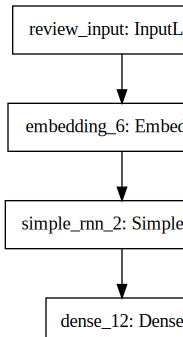

In [ ]:
# Add sequential model
sentiment_rnn_glove = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Rnn_Layer = SimpleRNN(100)
Rnn = Rnn_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Rnn)
predict = Dense(5,activation='softmax')(dense1)

sentiment_rnn_glove = Model(inputs=[review_input],outputs=[predict])
sentiment_rnn_glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_rnn_glove.summary())
SVG(model_to_dot(sentiment_rnn_glove).create(prog='dot', format='svg'))

In [ ]:
sentiment_rnn_glove.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 72s 53ms/step - loss: 1.0976 - acc: 0.6612 - val_loss: 1.0825 - val_acc: 0.6639
Epoch 2/5
1329/1329 [==============================] - 70s 53ms/step - loss: 1.0782 - acc: 0.6656 - val_loss: 1.0802 - val_acc: 0.6639
Epoch 3/5
1329/1329 [==============================] - 71s 54ms/step - loss: 1.0852 - acc: 0.6609 - val_loss: 1.0787 - val_acc: 0.6639
Epoch 4/5
1329/1329 [==============================] - 72s 55ms/step - loss: 1.0687 - acc: 0.6680 - val_loss: 1.0791 - val_acc: 0.6639
Epoch 5/5
1329/1329 [==============================] - 71s 53ms/step - loss: 1.0826 - acc: 0.6625 - val_loss: 1.0795 - val_acc: 0.6639


In [ ]:
test_loss, test_acc=sentiment_rnn_glove.evaluate(test_X,test_y)
pred_Y=sentiment_rnn_glove.predict(test_X)
print('Test Classification Report:')
predictions_glove=[]
for i in range(len(pred_Y)):
  predictions_glove.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions_glove))

313/313 [==============================] - 2s 5ms/step - loss: 1.2629 - acc: 0.5784
Test Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1271
           2       0.00      0.00      0.00       630
           3       0.00      0.00      0.00       911
           4       0.00      0.00      0.00      1404
           5       0.58      1.00      0.73      5784

    accuracy                           0.58     10000
   macro avg       0.12      0.20      0.15     10000
weighted avg       0.33      0.58      0.42     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Using LSTM Layer

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 52, 100)           1949100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 130       
Total params: 2,032,155
Trainable params: 2,032,155
Non-trainable params: 0
_________________________________________________________________
None


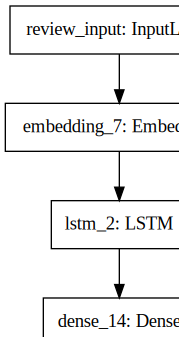

In [ ]:
# Add sequential model
sentiment_lstm_glove = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Lstm_Layer = LSTM(100)
Lstm = Lstm_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Lstm)
predict = Dense(5,activation='softmax')(dense1)

sentiment_lstm_glove = Model(inputs=[review_input],outputs=[predict])
sentiment_lstm_glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_lstm_glove.summary())
SVG(model_to_dot(sentiment_lstm_glove).create(prog='dot', format='svg'))

In [ ]:
sentiment_lstm_glove.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 29s 21ms/step - loss: 1.1265 - acc: 0.6362 - val_loss: 1.0791 - val_acc: 0.6639
Epoch 2/5
1329/1329 [==============================] - 27s 21ms/step - loss: 1.0813 - acc: 0.6631 - val_loss: 1.0792 - val_acc: 0.6639
Epoch 3/5
1329/1329 [==============================] - 27s 20ms/step - loss: 1.0801 - acc: 0.6632 - val_loss: 1.0789 - val_acc: 0.6639
Epoch 4/5
1329/1329 [==============================] - 27s 20ms/step - loss: 1.0772 - acc: 0.6654 - val_loss: 1.0795 - val_acc: 0.6639
Epoch 5/5
1329/1329 [==============================] - 27s 20ms/step - loss: 1.0828 - acc: 0.6622 - val_loss: 1.0798 - val_acc: 0.6639


In [ ]:
test_loss, test_acc=sentiment_lstm_glove.evaluate(test_X,test_y)
pred_Y=sentiment_lstm_glove.predict(test_X)
print('Test Classification Report:')
predictions_glove=[]
for i in range(len(pred_Y)):
  predictions_glove.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions_glove))

313/313 [==============================] - 1s 3ms/step - loss: 1.2755 - acc: 0.5784
Test Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1271
           2       0.00      0.00      0.00       630
           3       0.00      0.00      0.00       911
           4       0.00      0.00      0.00      1404
           5       0.58      1.00      0.73      5784

    accuracy                           0.58     10000
   macro avg       0.12      0.20      0.15     10000
weighted avg       0.33      0.58      0.42     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Bi-directional LSTM

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 52, 100)           1949100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_16 (Dense)             (None, 25)                5025      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 130       
Total params: 2,115,055
Trainable params: 2,115,055
Non-trainable params: 0
_________________________________________________________________
None


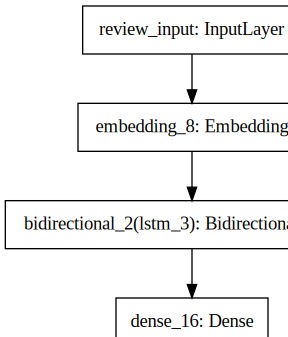

In [ ]:
# Add sequential model
sentiment_bilstm_glove = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Lstm_Layer = Bidirectional(LSTM(100))
Lstm = Lstm_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Lstm)
predict = Dense(5,activation='softmax')(dense1)

sentiment_bilstm_glove = Model(inputs=[review_input],outputs=[predict])
sentiment_bilstm_glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_bilstm_glove.summary())
SVG(model_to_dot(sentiment_bilstm_glove).create(prog='dot', format='svg'))

In [ ]:
sentiment_bilstm_glove.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 35s 24ms/step - loss: 0.9556 - acc: 0.6741 - val_loss: 0.6973 - val_acc: 0.7424
Epoch 2/5
1329/1329 [==============================] - 31s 23ms/step - loss: 0.6408 - acc: 0.7590 - val_loss: 0.6684 - val_acc: 0.7485
Epoch 3/5
1329/1329 [==============================] - 30s 23ms/step - loss: 0.5522 - acc: 0.7889 - val_loss: 0.6590 - val_acc: 0.7500
Epoch 4/5
1329/1329 [==============================] - 30s 23ms/step - loss: 0.4679 - acc: 0.8278 - val_loss: 0.6861 - val_acc: 0.7523
Epoch 5/5
1329/1329 [==============================] - 31s 23ms/step - loss: 0.4012 - acc: 0.8546 - val_loss: 0.7355 - val_acc: 0.7464


In [ ]:
test_loss, test_acc=sentiment_bilstm_glove.evaluate(test_X,test_y)
pred_Y=sentiment_bilstm_glove.predict(test_X)
print('Test Classification Report:')
predictions_glove=[]
for i in range(len(pred_Y)):
  predictions_glove.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions_glove))

313/313 [==============================] - 1s 4ms/step - loss: 0.8936 - acc: 0.6925
Test Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.67      0.65      1271
           2       0.26      0.18      0.21       630
           3       0.36      0.44      0.40       911
           4       0.42      0.25      0.32      1404
           5       0.83      0.90      0.86      5784

    accuracy                           0.69     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.67      0.69      0.68     10000



#GRU

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 52, 100)           1949100   
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_18 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 130       
Total params: 2,012,355
Trainable params: 2,012,355
Non-trainable params: 0
_________________________________________________________________
None


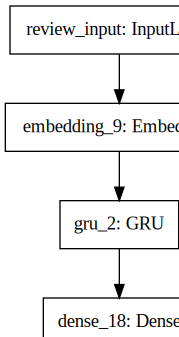

In [ ]:
# Add sequential model
sentiment_gru_glove = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Gru_Layer = GRU(100)
Gru = Gru_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Gru)
predict = Dense(5,activation='softmax')(dense1)

sentiment_gru_glove = Model(inputs=[review_input],outputs=[predict])
sentiment_gru_glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_gru_glove.summary())
SVG(model_to_dot(sentiment_gru_glove).create(prog='dot', format='svg'))

In [ ]:
sentiment_gru_glove.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 28s 20ms/step - loss: 1.0624 - acc: 0.6426 - val_loss: 0.7572 - val_acc: 0.7189
Epoch 2/5
1329/1329 [==============================] - 26s 19ms/step - loss: 0.6998 - acc: 0.7338 - val_loss: 0.6874 - val_acc: 0.7473
Epoch 3/5
1329/1329 [==============================] - 26s 20ms/step - loss: 0.5867 - acc: 0.7784 - val_loss: 0.6906 - val_acc: 0.7471
Epoch 4/5
1329/1329 [==============================] - 26s 20ms/step - loss: 0.5043 - acc: 0.8115 - val_loss: 0.7059 - val_acc: 0.7525
Epoch 5/5
1329/1329 [==============================] - 26s 20ms/step - loss: 0.4415 - acc: 0.8437 - val_loss: 0.7354 - val_acc: 0.7281


In [ ]:
test_loss, test_acc=sentiment_gru_glove.evaluate(test_X,test_y)
pred_Y=sentiment_gru_glove.predict(test_X)
print('Test Classification Report:')
predictions_glove=[]
for i in range(len(pred_Y)):
  predictions_glove.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions_glove))

313/313 [==============================] - 1s 3ms/step - loss: 0.8928 - acc: 0.6720
Test Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.69      0.67      1271
           2       0.29      0.18      0.22       630
           3       0.34      0.39      0.36       911
           4       0.34      0.36      0.35      1404
           5       0.85      0.84      0.85      5784

    accuracy                           0.67     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.67      0.67      0.67     10000



#Bi-Directional GRU

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 52)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 52, 100)           1949100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               121200    
_________________________________________________________________
dense_20 (Dense)             (None, 25)                5025      
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 130       
Total params: 2,075,455
Trainable params: 2,075,455
Non-trainable params: 0
_________________________________________________________________
None


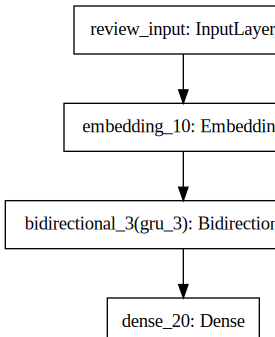

In [ ]:
# Add sequential model
sentiment_bigru_glove = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Glove 100d
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)
#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Gru_Layer = Bidirectional(GRU(100))
Gru = Gru_Layer(review_embedding)
output_size = 5
dense1= Dense(25,activation='sigmoid')(Gru)
predict = Dense(5,activation='softmax')(dense1)

sentiment_bigru_glove = Model(inputs=[review_input],outputs=[predict])
sentiment_bigru_glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(sentiment_bigru_glove.summary())
SVG(model_to_dot(sentiment_bigru_glove).create(prog='dot', format='svg'))

In [ ]:
sentiment_bigru_glove.fit(X_training,Y_training,epochs= 5,batch_size=32,verbose=True,validation_data=(X_validating,Y_validating))

Epoch 1/5
1329/1329 [==============================] - 33s 23ms/step - loss: 0.9753 - acc: 0.6657 - val_loss: 0.6879 - val_acc: 0.7456
Epoch 2/5
1329/1329 [==============================] - 30s 22ms/step - loss: 0.6468 - acc: 0.7562 - val_loss: 0.6524 - val_acc: 0.7501
Epoch 3/5
1329/1329 [==============================] - 29s 22ms/step - loss: 0.5463 - acc: 0.7924 - val_loss: 0.6578 - val_acc: 0.7489
Epoch 4/5
1329/1329 [==============================] - 30s 22ms/step - loss: 0.4574 - acc: 0.8340 - val_loss: 0.6917 - val_acc: 0.7549
Epoch 5/5
1329/1329 [==============================] - 29s 22ms/step - loss: 0.3866 - acc: 0.8641 - val_loss: 0.7440 - val_acc: 0.7383


In [ ]:
test_loss, test_acc=sentiment_bigru_glove.evaluate(test_X,test_y)
pred_Y=sentiment_bigru_glove.predict(test_X)
print('Test Classification Report:')
predictions_glove=[]
for i in range(len(pred_Y)):
  predictions_glove.append(np.argmax(pred_Y[i])+1)
print(classification_report(test_data.ratings,predictions_glove))

313/313 [==============================] - 1s 4ms/step - loss: 0.9187 - acc: 0.6804
Test Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.66      0.66      1271
           2       0.27      0.19      0.22       630
           3       0.36      0.42      0.39       911
           4       0.36      0.32      0.34      1404
           5       0.84      0.87      0.85      5784

    accuracy                           0.68     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.67      0.68      0.67     10000



In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_data.ratings,predictions_glove)

array([[ 837,  176,  141,   35,   82],
       [ 230,  118,  171,   47,   64],
       [  99,   99,  386,  185,  142],
       [  34,   26,  230,  450,  664],
       [  79,   19,  145,  528, 5013]])

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def predict(sentence,model,embedding):
  sent=sentence.lower()
  sent= remove_punctuation(sent)
  sent=word_tokenize(sent)
  sent=tokenizer.texts_to_sequences(sent)
  sentence=[]
  for i in sent:
    for j in i:
      sentence.append(j)
  while len(sentence)!=MAX_SEQUENCE_LENGTH:
    if len(sentence)<MAX_SEQUENCE_LENGTH:
      sentence.append(0)
    else:
      sentence.pop()
  sentence=np.array(sentence) 
  sentence=(np.expand_dims(sentence,0))
  if model == "RNN" and embedding == False:
    probable=sentiment_rnn.predict(sentence)
  elif model == "RNN" and embedding == True:
    probable=sentiment_rnn_glove.predict(sentence)
  elif model == "LSTM" and embedding == False:
    probable=sentiment_lstm.predict(sentence)
  elif model == "LSTM" and embedding == True:
    probable=sentiment_lstm_glove.predict(sentence)
  elif model == "Bi-LSTM" and embedding == False:
    probable=sentiment_bilstm.predict(sentence)
  elif model == "Bi-LSTM" and embedding == True:
    probable=sentiment_bilstm_glove.predict(sentence)
  elif model == "GRU" and embedding == False:
    probable=sentiment_gru.predict(sentence)
  elif model == "GRU" and embedding == True:
    probable=sentiment_gru_glove.predict(sentence)
  elif model == "Bi-GRU" and embedding == False:
    probable=sentiment_bigru.predict(sentence)
  elif model == "Bi-GRU" and embedding == True:
    probable=sentiment_bigru_glove.predict(sentence)

  return {'Class 1': probable[0][0]*100/100,
          'Class 2': probable[0][1]*100/100,
          'Class 3': probable[0][2]*100/100,
          'Class 4': probable[0][3]*100/100,
          'Class 5': probable[0][4]*100/100}

iface = gr.Interface(
    predict,
    [
        gr.inputs.Textbox(),
        gr.inputs.Dropdown(["RNN","LSTM","Bi-LSTM","GRU","Bi-GRU"]),
        gr.inputs.Checkbox(label="embedding"),
    ],
    outputs = 'label',
    interpretation="default",
    title = "Sentiment Analysis" )
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://59870.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7870/',
 'https://59870.gradio.app')